In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import math
import matplotlib
import seaborn as sns



# read data from csv file
df = pd.read_csv('autos.csv', sep=',', header=0, encoding='cp1252')
df = df.head(700)

# Check data information
df.info()


# Check data statistics
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 20 columns):
dateCrawled            700 non-null object
name                   700 non-null object
seller                 700 non-null object
offerType              700 non-null object
price                  700 non-null int64
abtest                 700 non-null object
vehicleType            613 non-null object
yearOfRegistration     700 non-null int64
gearbox                648 non-null object
powerPS                700 non-null int64
model                  663 non-null object
kilometer              700 non-null int64
monthOfRegistration    700 non-null int64
fuelType               626 non-null object
brand                  700 non-null object
notRepairedDamage      555 non-null object
dateCreated            700 non-null object
nrOfPictures           700 non-null int64
postalCode             700 non-null int64
lastSeen               700 non-null object
dtypes: int64(7), object(13)
memory usage:

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.0,700.000000
mean,5655.174286,2002.172857,111.605714,125521.428571,6.047143,0.0,50151.921429
std,7702.125634,34.803764,73.394296,40077.440748,3.778079,0.0,26089.575996
min,0.000000,1111.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1200.000000,1999.000000,69.000000,100000.000000,3.000000,0.0,29221.000000
50%,2990.000000,2004.000000,105.000000,150000.000000,6.000000,0.0,49647.500000
75%,7625.000000,2009.000000,150.000000,150000.000000,9.000000,0.0,70390.750000
max,90500.000000,2018.000000,510.000000,150000.000000,12.000000,0.0,99867.000000


In [2]:

'''
수 데이터들의 통계적인 수치들을 확인할 수 있었다.
- Price는 값이 0인 데이터들도 존재한다.
- yearOfRegistration은 1000년대 초반 데이터부터 존재했다.
- kilometer는 150000인 값이 많았으며, 최저와 최고 값의 차이가 매우 컸다.
- powerPS는 값이 0인 데이터들도 존재한다.
- nrOfPicutrees는 모든 값이 0을 가지고 있었다.
'''


print(len(df['name'].unique()))
print(len(df['postalCode'].unique()))
# postal code의 값은 주소 코드를 의미하는데 매우 많은 값으로 분포되어 있었다.

print(df['seller'].value_counts())
print(df['offerType'].value_counts())
# seller, offer type는 거의 모두 하나의 값으로 다 수렴하고 있었다.


689
643
privat    700
Name: seller, dtype: int64
Angebot    700
Name: offerType, dtype: int64


['abtest', 'vehicleType', 'gearbox', 'model', 'fuelType', 'brand', 'notRepairedDamage']


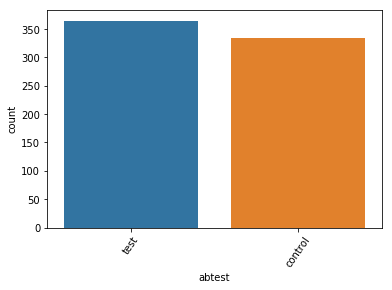

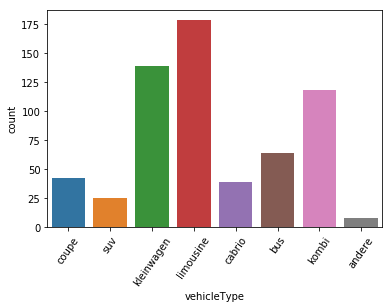

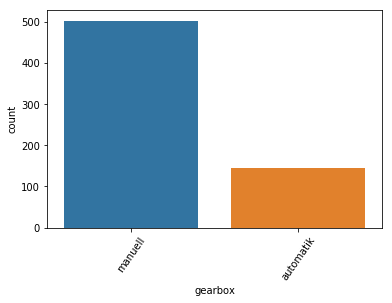

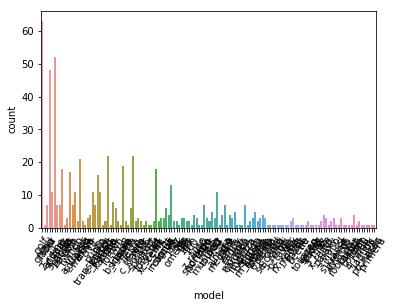

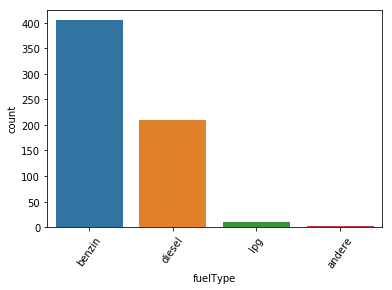

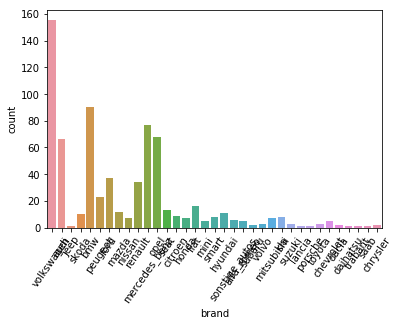

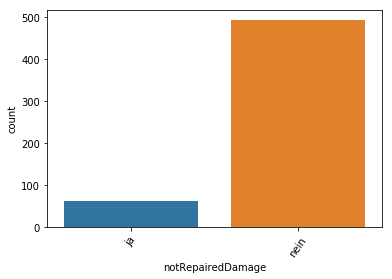

'\n카테고리 데이터들의 히스토그램을 볼 수 있었다.\ngearbox와 notRepairedDamage의 경우, 값이 한쪽으로 많이 쏠려있었다.\nfuelType의 경우에도 다른 값에 비해 너무 적은 데이터들이 존재했다.\n'

In [3]:

# Restructuring -> Vertical Decomposition
# drop low impact data on price
# 1. 데이터가 대부분 하나의 값으로 수렴하는 경우 (seller, offerType, nrOfPictures)
# 2. 목표인 가격을 예측하는 것과 생관없는 경우 (dateCrawled, lastSeen, dateCreated)
# 3. 각기 다 다른 값을 가지는 경우 (name, postalCode)
df.drop(['seller', 'offerType', 'nrOfPictures', 'dateCrawled', 'lastSeen', 'dateCreated', 'postalCode', 'name'], axis='columns', inplace=True)


# Remove unusable data(redundant data)
df = df.drop_duplicates(['price','vehicleType','yearOfRegistration'
                         ,'gearbox','powerPS','model','kilometer','monthOfRegistration','fuelType'
                         ,'notRepairedDamage'])



category_feature = [col for col in df.columns if df[col].dtypes == 'object' and col != 'name']
print(category_feature)

for col in category_feature:
    sns.countplot(x = col, data = df)
    plt.xticks(rotation=55)
    plt.show()
    
'''
카테고리 데이터들의 히스토그램을 볼 수 있었다.
gearbox와 notRepairedDamage의 경우, 값이 한쪽으로 많이 쏠려있었다.
fuelType의 경우에도 다른 값에 비해 너무 적은 데이터들이 존재했다.
'''
    

['price', 'yearOfRegistration', 'powerPS', 'kilometer', 'monthOfRegistration']


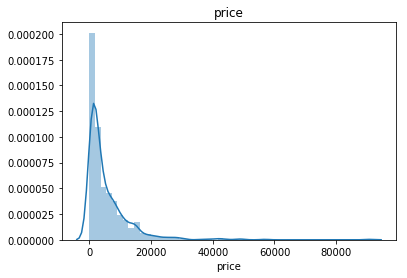

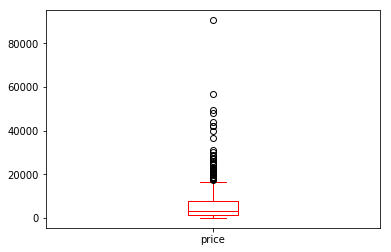

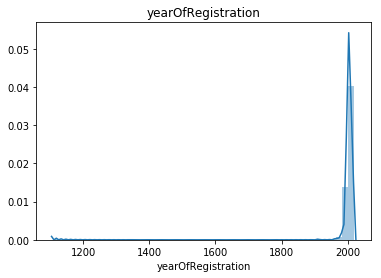

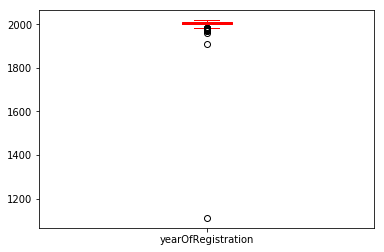

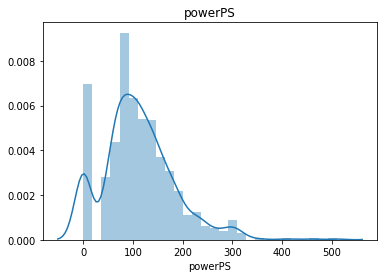

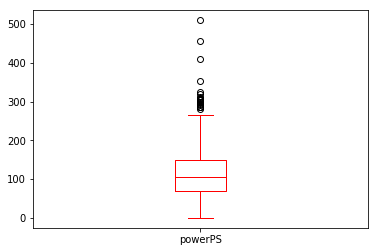

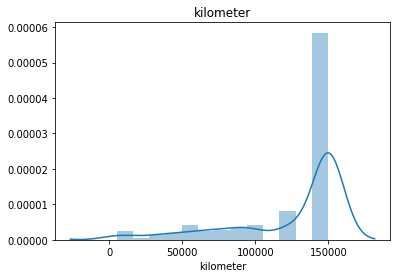

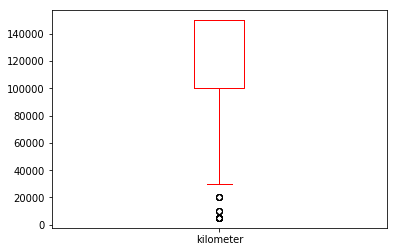

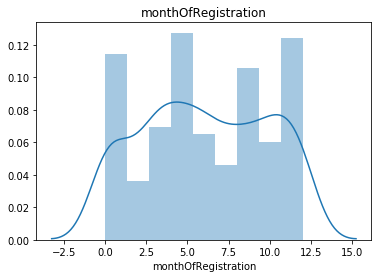

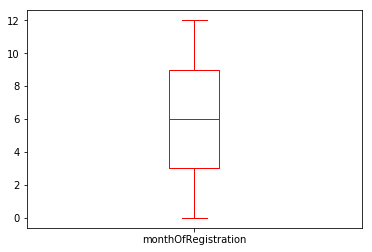

In [4]:

numerical_feature = [col for col in df.columns if df[col].dtypes == 'int64']
print(numerical_feature)

def dist_box(df, feature_list):
    for col in feature_list:
        sns.distplot(df.loc[df[col].notnull(), col])
        plt.title(col)
        plt.show()
        df[col].plot(kind='box', color='red')
        plt.show()
# 수 데이터들의 분포와 box plot을 볼 수 있다.

dist_box(df, numerical_feature)
'''
- price, yearOfRegistration 데이터 분포가 skewed한 형태를 띈다. (분포가 몰려있다)
- 모든 feature의 데이터들에서 조금씩의 outlier들이 존재한다.

'''
# 앞을 통해 본 데이터들로 Wrong data, Outlier를 제거한다.
# Remove the outliers and wrong data
df = df[(df.yearOfRegistration <= 2019)
    & (df.yearOfRegistration >= 1970)
    & (df.price >= 100)
    & (df.price <= 60000)
    & (df.powerPS >= 10)
    & (df.powerPS <= 400)]

 



In [5]:

# Missing data
df.isnull().sum()

# 'model' of car
df = df[df['model'].notnull()]

# Replace null with others
# Replace with the most value according to model type.
# value_counts() --> 맨 위 최빈값.
# 모델 종류를 다 돌아가면서 VehicleType, fuleType, gearbox 중 missing 값인 경우, 해당 모델의 최빈값을 가져와 채움.

for i in range(len(df['model'].unique())) :
    df["vehicleType"].fillna(df.vehicleType[df["model"]==df['model'].unique()[i]].value_counts().index[0], inplace=True)
    df["fuelType"].fillna(df.fuelType[df["model"]==df['model'].unique()[i]].value_counts().index[0], inplace=True)
    df["gearbox"].fillna(df.gearbox[df["model"]==df['model'].unique()[i]].value_counts().index[0], inplace=True)

# null in 'notRepairedDamage' is one of the deciding factors for price prediction.
# -> replace null with 'nein' that means "NO" in English ==> mode value
df["notRepairedDamage"].fillna(value='nein', inplace=True)

# Check the misting data is processed.
print(df.isnull().sum())
print(len(df))



price                  0
abtest                 0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
dtype: int64
574


In [6]:
# columns that value is string
les = {}


# label encoder
# encode string columns to 0~k-1 labels
for l in category_feature:
    les[l] = preprocessing.LabelEncoder()
    les[l].fit(df[l].astype(str))
    tr = les[l].transform(df[l].astype(str))
    df.loc[:, l + '_encode'] = pd.Series(tr, index=df.index)

# extract only necessary columns to analysis
df = df[ ['price'
                ,'yearOfRegistration'
                ,'powerPS'
                ,'kilometer'
                ,'monthOfRegistration']
                + [x+"_encode" for x in category_feature]]


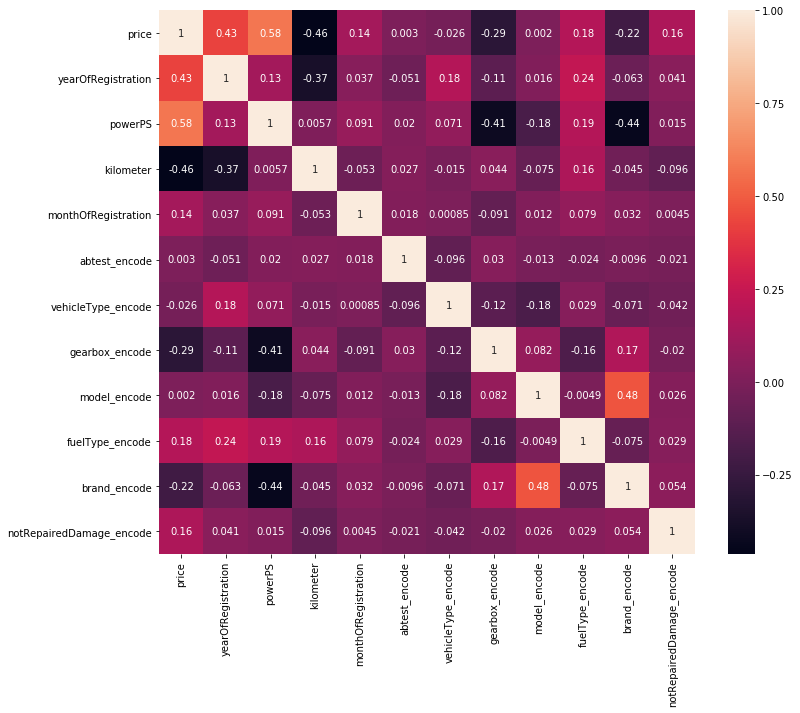

In [7]:

# correlation
# calculate the correlation matrix
corr = df.corr()
# adjust matrix size to (12, 10)
plt.subplots( figsize =( 12 , 10 ) )
# plot the correlation heatmap
sns.heatmap(corr,
        annot=True,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [8]:
# price와 제일 correlation 관계가 없는 abtest, vehicleType, model을 삭제
df.drop(['abtest_encode', 'vehicleType_encode', 'model_encode'], axis='columns', inplace=True)


In [9]:

# normalization
df['price']= np.log(df['price'])
# standardization
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler

#scaler = StandardScaler()
#scaler = RobustScaler()
scaler = MinMaxScaler()
#scaler = MaxAbsScaler()
# 제일 정확도가 높은 MinMaxScaler 사용
df[numerical_feature] = scaler.fit_transform(df[numerical_feature])


# Split X and Y
# Y --> price column
# X --> data without price column
Y = df['price']
X = df.drop(['price'], axis=1, inplace=False)

print(X['yearOfRegistration'])

2      0.688889
3      0.622222
4      0.777778
5      0.488889
6      0.688889
8      0.911111
9      0.555556
10     0.688889
11     0.711111
12     0.488889
13     0.688889
14     0.844444
16     0.955556
17     0.688889
18     0.755556
19     0.688889
20     0.800000
21     0.644444
22     1.000000
23     0.533333
24     0.377778
25     0.644444
26     0.977778
27     0.777778
28     0.177778
29     0.666667
30     0.488889
31     0.955556
33     0.755556
34     0.688889
         ...   
655    0.800000
656    0.977778
659    0.533333
661    0.977778
662    0.755556
663    0.666667
664    0.777778
665    0.977778
666    0.666667
668    0.777778
670    0.733333
671    0.800000
673    0.800000
674    0.955556
675    0.622222
676    0.866667
679    0.577778
681    0.644444
682    0.511111
683    0.733333
685    0.800000
686    0.800000
687    0.533333
688    0.577778
689    0.711111
691    0.577778
693    0.511111
694    0.622222
695    0.844444
696    0.755556
Name: yearOfRegistration

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


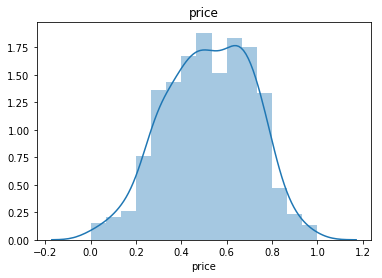

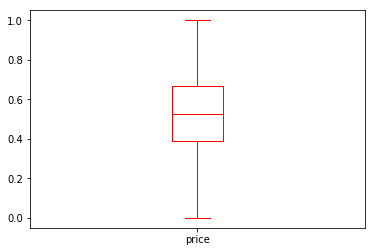

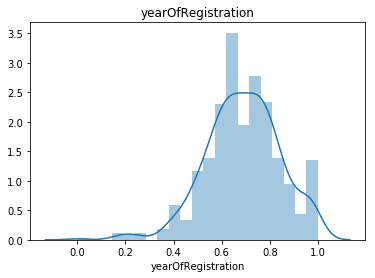

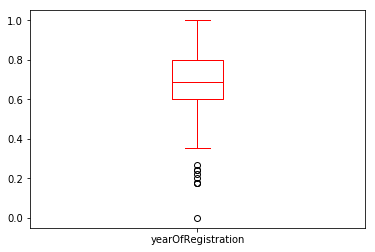

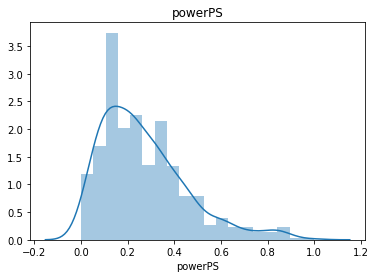

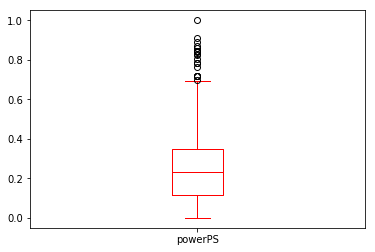

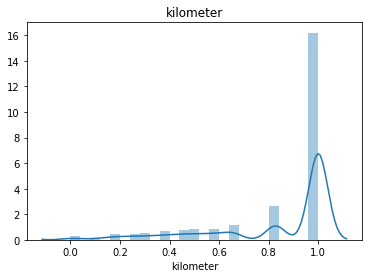

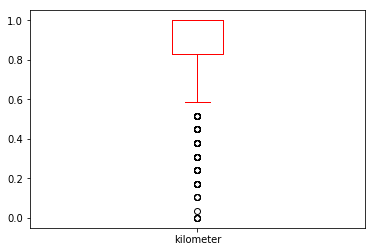

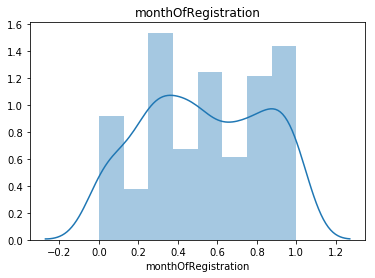

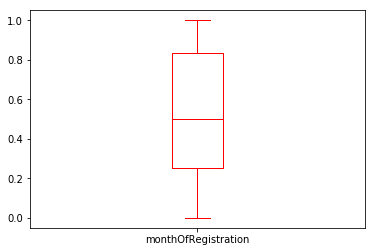

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


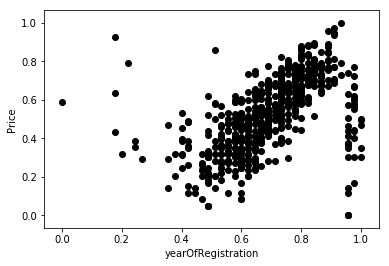

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


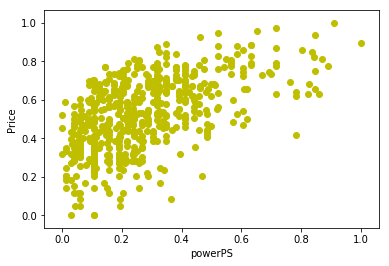

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


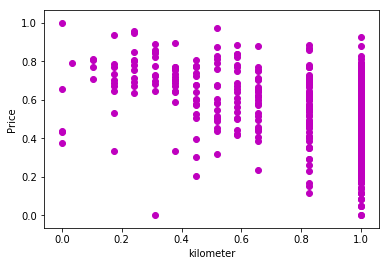

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


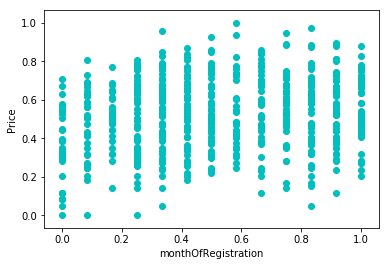

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


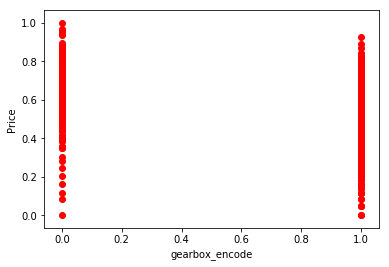

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


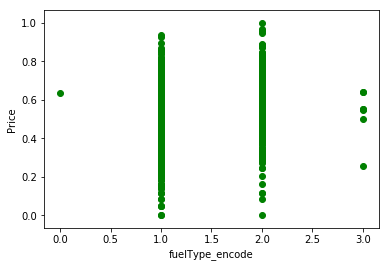

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


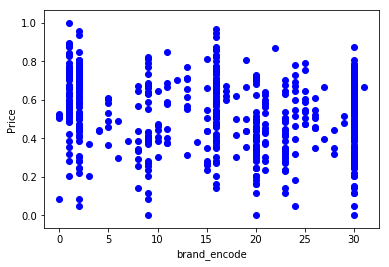

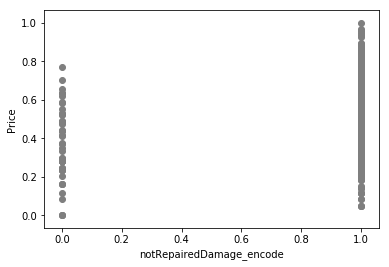

In [10]:
dist_box(df, numerical_feature)
import matplotlib.colors as colors
colors_list = list(colors._colors_full_map.values())

colors_list.pop()
for col in X.columns:
    plt.scatter(X[col], Y, c=colors_list.pop())
    plt.xlabel(col)
    plt.ylabel('Price')
    plt.show()
    
# year이 높을 수록 가격이 내려가는 추세 ==> 이상. 아웃라이어 지정?
# fuelType 데이터 매우 적은 카테고리 존재 ==> 삭제?
# 
    

Decision Tree Score :  0.5627512921165954


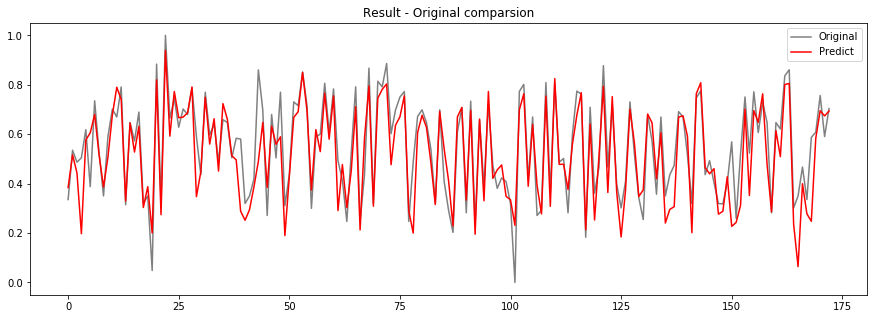

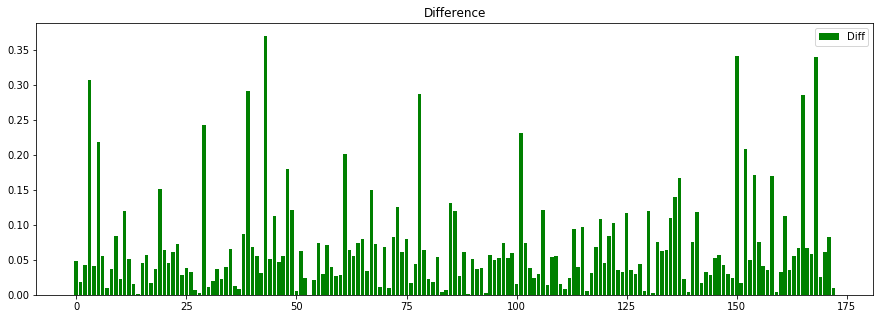

Out-of-bag score estimate: 0.736
MAPE: 
0.12468604737534009
Accuracy using MAPE: 
0.8753139526246599


In [12]:
# Divide data into training data and test data (70% training data, 30% test data)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=123)



decisionTree = DecisionTreeRegressor().fit(X_train, y_train) # make decisionTreeRegressor model for predict dependent value
predictDecision = decisionTree.predict(X_test) # predict dependent value to test data and assign 'predictDecision'
score = decisionTree.score(X_test, y_test) # accuracy for result of predictition
print("Decision Tree Score : ",score)





# In[45]:

# Using ensemble learning for regression
# ==> RandomForestRegressor
# n_estimators: The number of trees in the forest
# oob_score: out of bagging score
randomForest = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=123)
randomForest.fit(X_train, y_train)


# In[47]:

# predict data using X_test
predicted = randomForest.predict(X_test)
y_predict = pd.Series(predicted) # make series of pandas

# print test data, predict data
# print("\nTEST")
# print(y_test)
# print("PREDICT")
# print(y_predict)


# In[19]:


# Resets index to compare original test data with predicted data
y_test = y_test.reset_index(drop=True)
y_predict = y_predict.reset_index(drop=True)

plt.figure(figsize=(15, 5))
plt.plot(range(y_test.shape[0]), y_test, c='gray')
plt.plot(range(y_predict.shape[0]), y_predict , c='r')
plt.title('Result - Original comparsion')
plt.legend(['Original', 'Predict'])
plt.show()

plt.figure(figsize=(15, 5))
diff = abs(y_test - y_predict)
plt.bar(range(y_test.shape[0]), diff, color='g')
plt.title('Difference')
plt.legend(['Diff'])
plt.show()


# print out of bag score
# Testing with samples not used in training.
print(f'Out-of-bag score estimate: {randomForest.oob_score_:.3}')


# In[20]:


# MAPE(mean absolute percentage error)
# : measure of prediction accuracy of a forecasting method
def MAPE(actual, predict):

    sum_actuals = sum_errors = 0

    for actual_val, predict_val in zip(actual, predict):
        abs_error = actual_val - predict_val # calculate error
        if abs_error < 0:
            abs_error = abs_error * -1

        sum_errors = sum_errors + abs_error
        sum_actuals = sum_actuals + actual_val

    # calculate and print MAPE
    mean_abs_percent_error = sum_errors / sum_actuals
    print("MAPE: ")
    print(mean_abs_percent_error)
    # calculate accuracy
    print("Accuracy using MAPE: ")
    print(1-mean_abs_percent_error)


# In[15]:
MAPE(y_test, y_predict)

